# Speech Recognition Project: DeepFake Voice Recognition
**Kelompok 3**
1. DAVE ANELKA ALIM 2602102712
2. NICHOLAS FARANDI HARJANTO 2602065553
3. DEANZEN LIE 2602115785
4. DAVE TJONG 2602077736
5. KEVIN BRIVIO 2602077263
6. CHRISTIAN LUIS EFENDY 2602106963
7. STANLEY BENEDICT KODYAT 2602103463

Dataset (kaggle): https://www.kaggle.com/datasets/birdy654/deep-voice-deepfake-voice-recognition/data



## Libraries

### Importing Libraries

In [2]:
import numpy as np, pandas as pd, os, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Reshape,MaxPooling2D, Dropout, Conv2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

import librosa

import joblib
from joblib import Parallel, delayed
import multiprocessing

# Preprocessing

In [14]:
fake_dir = 'KAGGLE/AUDIO/FAKE'
real_dir = 'KAGGLE/AUDIO/REAL'

# Function to extract audio features from a chunk of files
def extract_features_from_chunk(files):
    chunk_features = []
    for file_path in files:
        try:
            y, sr = librosa.load(file_path, sr=None)
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
            spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
            spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
            spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
            zero_crossing_rate = librosa.feature.zero_crossing_rate(y)
            chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
            rms = librosa.feature.rms(y=y)

            # Calculate mean of each feature
            features = {
                'mfcc': np.mean(mfcc, axis=1),
                'spectral_centroid': np.mean(spectral_centroid),
                'spectral_bandwidth': np.mean(spectral_bandwidth),
                'spectral_rolloff': np.mean(spectral_rolloff),
                'zero_crossing_rate': np.mean(zero_crossing_rate),
                'chroma_stft': np.mean(chroma_stft, axis=1),
                'rms': np.mean(rms)
            }
            print
            chunk_features.append(features)
        except Exception as e:
            print(f"Error encountered while processing {file_path}: {e}")
    return chunk_features

# Function to process files in parallel with chunking for loading files
def process_files_in_parallel_with_chunking(directory, chunk_size=16):
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.wav')]

    num_chunks = len(files) // chunk_size + 1
    chunks = [files[i:i + chunk_size] for i in range(0, len(files), chunk_size)]

    print(f"Processing {len(files)} files in {num_chunks} chunks.")

    # Process each chunk in parallel
    results = Parallel(n_jobs=multiprocessing.cpu_count(), verbose=10)(delayed(extract_features_from_chunk)(chunk) for chunk in chunks)
    
    # Flatten the list of lists into a single list of features
    return [feature for chunk_features in results for feature in chunk_features]

# Process real audio files
print("Processing real audio files...")
real_features = process_files_in_parallel_with_chunking(real_dir)

# Process fake audio files
print("Processing fake audio files...")
fake_features = process_files_in_parallel_with_chunking(fake_dir)


# Create DataFrame
fake_df = pd.DataFrame(fake_features)
real_df = pd.DataFrame(real_features)

# Add labels
fake_df['label'] = 0
real_df['label'] = 1

# Concatenate both DataFrames
combined_df = pd.concat([fake_df, real_df], ignore_index=True)

# Save DataFrame to CSV or perform further analysis
combined_df.to_csv('audio_features.csv', index=False)

print("Feature extraction and DataFrame creation completed")


Processing fake audio files...
Processing 56 files in 4 chunks.


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   1 tasks      | elapsed:  2.8min
[Parallel(n_jobs=16)]: Done   2 out of   4 | elapsed:  3.3min remaining:  3.3min
[Parallel(n_jobs=16)]: Done   4 out of   4 | elapsed:  4.2min finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


Processing real audio files...
Processing 8 files in 1 chunks.
Feature extraction and DataFrame creation completed with chunking for loading files and verbose messaging.


[Parallel(n_jobs=16)]: Done   1 tasks      | elapsed:  1.5min


# Load Data

In [258]:
df = pd.read_csv("audio_features.csv")
df.head()

,mfcc,spectral_centroid,spectral_bandwidth,spectral_rolloff,zero_crossing_rate,chroma_stft,rms,label
0,[-302.54306 127.27121 -14.283487 1.7...,2599.967190,3117.879837,4654.397689,0.064894,[0.3496129 0.3380766 0.36858195 0.4280699 0...,0.076937,0
1,[-300.31802 120.79766 -15.355717 -4.4...,2156.127616,2624.293959,3531.647811,0.055173,[0.42251062 0.40072218 0.3973518 0.36861905 0...,0.095037,0
2,[-3.1964563e+02 1.5258853e+02 -2.5556074e+01 ...,2286.768041,2748.406401,4366.304431,0.054891,[0.34814063 0.35492334 0.38553256 0.4300596 0...,0.061640,0
3,[-309.4732 123.49691 -15.971551 3.4...,2293.790757,2795.999966,4012.721062,0.061600,[0.41488966 0.4037014 0.40888336 0.39359272 0...,0.054449,0
4,[-296.7996 100.658165 -33.14746 3.2...,2981.977236,3231.058001,5455.423262,0.074585,[0.38841832 0.3894226 0.3859044 0.38315785 0...,0.075206,0


In [259]:
df['mfcc']

df_mfcc = df['mfcc'].str.strip('[]').str.split(expand=True)
df_mfcc = df_mfcc.astype(float)
df_mfcc.columns = [f'mfcc{i+1}' for i in range(len(df_mfcc.columns))]
df = pd.concat([df.drop('mfcc', axis=1), df_mfcc], axis=1)

In [260]:
df_stft = df['chroma_stft'].str.strip('[]').str.split(expand=True)
df_stft = df_stft.astype(float)
df_stft.columns = [f'chroma_stft{i+1}' for i in range(len(df_stft.columns))]
df = pd.concat([df.drop('chroma_stft', axis=1), df_stft], axis=1)

In [261]:
df.head()

,spectral_centroid,spectral_bandwidth,spectral_rolloff,zero_crossing_rate,rms,label,mfcc1,mfcc2,mfcc3,mfcc4,...,chroma_stft3,chroma_stft4,chroma_stft5,chroma_stft6,chroma_stft7,chroma_stft8,chroma_stft9,chroma_stft10,chroma_stft11,chroma_stft12
0,2599.967190,3117.879837,4654.397689,0.064894,0.076937,0,-302.54306,127.271210,-14.283487,1.716690,...,0.368582,0.428070,0.406456,0.410833,0.426319,0.452979,0.468287,0.424683,0.376906,0.357925
1,2156.127616,2624.293959,3531.647811,0.055173,0.095037,0,-300.31802,120.797660,-15.355717,-4.453233,...,0.397352,0.368619,0.290051,0.289910,0.313331,0.336051,0.349939,0.332473,0.337088,0.393585
2,2286.768041,2748.406401,4366.304431,0.054891,0.061640,0,-319.64563,152.588530,-25.556074,-0.054273,...,0.385533,0.430060,0.394099,0.396534,0.423433,0.454422,0.468046,0.429351,0.376090,0.366622
3,2293.790757,2795.999966,4012.721062,0.061600,0.054449,0,-309.47320,123.496910,-15.971551,3.467139,...,0.408883,0.393593,0.319935,0.319800,0.337413,0.363444,0.382329,0.378939,0.382013,0.411680
4,2981.977236,3231.058001,5455.423262,0.074585,0.075206,0,-296.79960,100.658165,-33.147460,3.257424,...,0.385904,0.383158,0.311291,0.293473,0.304940,0.336300,0.384716,0.373585,0.382593,0.386722


In [262]:
df.shape

(64, 31)

In [263]:
df = shuffle(df, random_state=42)
df

,spectral_centroid,spectral_bandwidth,spectral_rolloff,zero_crossing_rate,rms,label,mfcc1,mfcc2,mfcc3,mfcc4,...,chroma_stft3,chroma_stft4,chroma_stft5,chroma_stft6,chroma_stft7,chroma_stft8,chroma_stft9,chroma_stft10,chroma_stft11,chroma_stft12
52,2429.113681,2794.925400,4681.912522,0.062044,0.055236,0,-317.70291,150.829220,-21.754906,13.694697,...,0.409830,0.399756,0.393319,0.416811,0.435916,0.447735,0.467633,0.487259,0.462858,0.435644
58,2735.721390,2710.950302,4797.724711,0.080685,0.034534,1,-331.50803,140.447420,-41.911015,27.003574,...,0.327963,0.323882,0.366394,0.409067,0.404436,0.422802,0.414835,0.427437,0.417866,0.392760
0,2599.967190,3117.879837,4654.397689,0.064894,0.076937,0,-302.54306,127.271210,-14.283487,1.716690,...,0.368582,0.428070,0.406456,0.410833,0.426319,0.452979,0.468287,0.424683,0.376906,0.357925
44,3632.001761,3562.355180,6248.531383,0.113748,0.010894,0,-462.96295,98.258010,-8.441978,16.123634,...,0.424589,0.472250,0.479013,0.456566,0.425311,0.397514,0.364571,0.351658,0.347589,0.386003
5,3304.672156,3241.036007,6164.012310,0.086404,0.064656,0,-302.35858,103.568010,-36.277720,19.733465,...,0.390275,0.393265,0.345945,0.333365,0.348903,0.388979,0.409503,0.378640,0.377245,0.401022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42,3359.212189,3277.455875,5992.654597,0.103719,0.054288,0,-328.48070,100.096306,-6.963940,31.538004,...,0.498942,0.480716,0.488364,0.467286,0.438372,0.450609,0.498552,0.495125,0.483089,0.484057
14,2541.632669,2753.286311,4492.674669,0.070679,0.071381,0,-298.96002,128.248020,-12.640800,27.359493,...,0.495685,0.479084,0.465949,0.427216,0.394207,0.379062,0.372777,0.352055,0.349326,0.370833
28,3018.028622,3335.591684,5734.879323,0.082000,0.043087,0,-373.91318,91.474560,-7.028577,3.069882,...,0.378387,0.376451,0.376007,0.406715,0.429106,0.457675,0.489115,0.483195,0.446720,0.429246
51,2526.966134,2671.761412,4348.306206,0.069987,0.078768,0,-300.49673,109.687600,-21.899088,-1.879614,...,0.333475,0.339548,0.339892,0.372329,0.401077,0.407440,0.383505,0.381264,0.350638,0.344827


# model

In [295]:
x = df.drop('label', axis=1)
y = df['label']

In [296]:
x = x.to_numpy()
x = x.reshape(-1, 30, 1, 1)
print(x)
print(x.shape)

input_shape = x.shape[1:]

[[[[2.42911368e+03]]

  [[2.79492540e+03]]

  [[4.68191252e+03]]

  ...

  [[4.87258640e-01]]

  [[4.62857600e-01]]

  [[4.35643580e-01]]]


 [[[2.73572139e+03]]

  [[2.71095030e+03]]

  [[4.79772471e+03]]

  ...

  [[4.27437100e-01]]

  [[4.17866350e-01]]

  [[3.92760070e-01]]]


 [[[2.59996719e+03]]

  [[3.11787984e+03]]

  [[4.65439769e+03]]

  ...

  [[4.24683200e-01]]

  [[3.76905700e-01]]

  [[3.57924550e-01]]]


 ...


 [[[3.01802862e+03]]

  [[3.33559168e+03]]

  [[5.73487932e+03]]

  ...

  [[4.83194980e-01]]

  [[4.46719700e-01]]

  [[4.29246220e-01]]]


 [[[2.52696613e+03]]

  [[2.67176141e+03]]

  [[4.34830621e+03]]

  ...

  [[3.81264200e-01]]

  [[3.50638420e-01]]

  [[3.44827030e-01]]]


 [[[2.62576131e+03]]

  [[3.03323479e+03]]

  [[5.31047479e+03]]

  ...

  [[5.29120200e-01]]

  [[5.16719160e-01]]

  [[4.93524850e-01]]]]
(64, 30, 1, 1)


In [297]:
y

52    0
58    1
0     0
44    0
5     0
     ..
42    0
14    0
28    0
51    0
38    0
Name: label, Length: 64, dtype: int64

In [298]:
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size = 0.2,random_state=42)

In [300]:
model = Sequential([
    Conv2D(8, kernel_size=(3, 1), activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2, 1)),
    Flatten(),
    Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

c:\Users\kodya\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [301]:
# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Tampilkan ringkasan model
model.summary()

# EarlyStop kalau overfit
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


# Train model
history = model.fit(xtrain,ytrain,
                    epochs=30, 
                    batch_size=16, 
                    validation_data=(xtest, ytest),
                    callbacks=[early_stopping])

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)              │ (None, 28, 1, 8)       │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 14, 1, 8)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_25 (Flatten)            │ (None, 112)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 16)             │         1,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,857 (7.25 KB)

 Trainable params: 1,857 (7.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.6828 - loss: 33.7753 - val_accuracy: 0.8462 - val_loss: 33.4580
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7064 - loss: 41.6025 - val_accuracy: 0.8462 - val_loss: 26.4096
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8377 - loss: 14.4849 - val_accuracy: 0.8462 - val_loss: 22.3805
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8216 - loss: 18.4909 - val_accuracy: 0.8462 - val_loss: 19.6867
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7966 - loss: 15.9863 - val_accuracy: 0.8462 - val_loss: 19.6954
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7496 - loss: 34.9849 - val_accuracy: 0.8462 - val_loss: 21.1670
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7069 - loss: 36.6856 - val_accuracy: 0.8462 - val_loss: 24.3329
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8299 - loss: 22.1058 - val_accuracy: 0.8462 - va

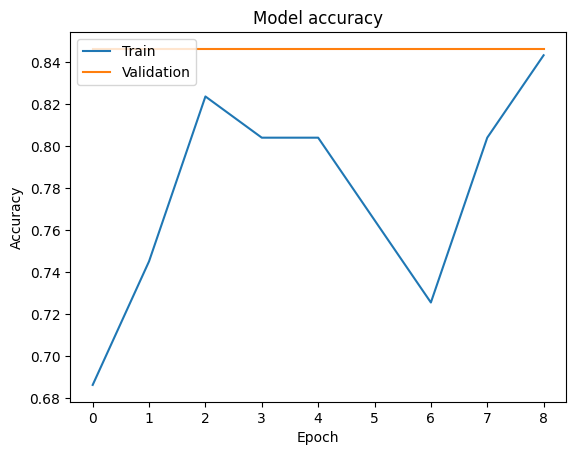

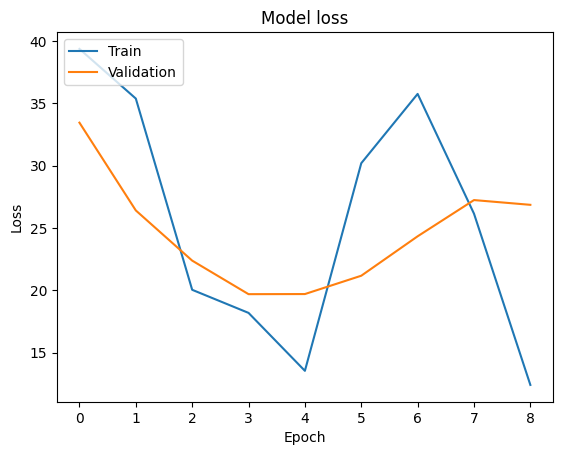

In [302]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [303]:
# Assuming X_test and y_test are your test data
test_loss, test_accuracy = model.evaluate(xtest, ytest)

print(f'Test accuracy: {test_accuracy}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8462 - loss: 19.6867
Test accuracy: 0.8461538553237915
